# Imports

## Packages

In [1]:
import pandas as pd
import datetime as dt
# from datetime import datetime, timezone
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import xgboost as xg
from entsoe import EntsoePandasClient
from statsmodels.graphics import tsaplots

C:\Users\Elena\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Elena\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Elena\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Data

In [2]:
# Load the data into a Pandas DataFrame
df = pd.read_csv('DK_2.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format = '%Y %m %d %H:%M:%S')
df.head()

Timestamp        Date  TTF  CO2  Day-ahead prices  \
0 2018-01-01 00:00:00  2018-01-01  NaN  NaN             26.33   
1 2018-01-01 01:00:00  2018-01-01  NaN  NaN             26.43   
2 2018-01-01 02:00:00  2018-01-01  NaN  NaN             26.10   
3 2018-01-01 03:00:00  2018-01-01  NaN  NaN             24.70   
4 2018-01-01 04:00:00  2018-01-01  NaN  NaN             24.74   

   Forecasted Load  Actual Load  Solar  Wind Offshore  Wind Onshore  \
0           3422.0       3421.0    0.0          783.0        1493.0   
1           3289.0       3308.0    0.0          893.0        1481.0   
2           3157.0       3118.0    0.0          755.0        1430.0   
3           3025.0       3018.0    0.0          747.0        1458.0   
4           2939.0       2916.0    0.0          886.0        1472.0   

   Wind Total  
0      2276.0  
1      2374.0  
2      2185.0  
3      2205.0  
4      2358.0

In [31]:
# add year, quarter, month, day, date and hour columns
def get_dt_info(df, dt_col, yr = False, qt = False, mo = False, day = False, date = False, w = False, h = False):
    if yr:
        df['Year'] = df[dt_col].dt.year
    if qt:
        df['Quarter'] = df[dt_col].dt.quarter
    if mo:
        df['Month'] = df[dt_col].dt.month
    if day:
        df['Day'] = df[dt_col].dt.day
    if date:
        df['Date'] = df[dt_col].dt.date
        df['Date'] = pd.to_datetime(df['Date'], format = '%Y %m %d')
    if w:
        if df[dt_col].dtype == '<M8[ns]':
            df['Week'] = df[dt_col].dt.isocalendar().week
        else:
            print(dt_col,'is not a date!')
    if h:
        df['Hour'] = df[dt_col].dt.hour
        
    return df

In [4]:
df = get_dt_info(df, 'Timestamp', yr = True, qt = True, mo = True, day = True, date = True, h = True)

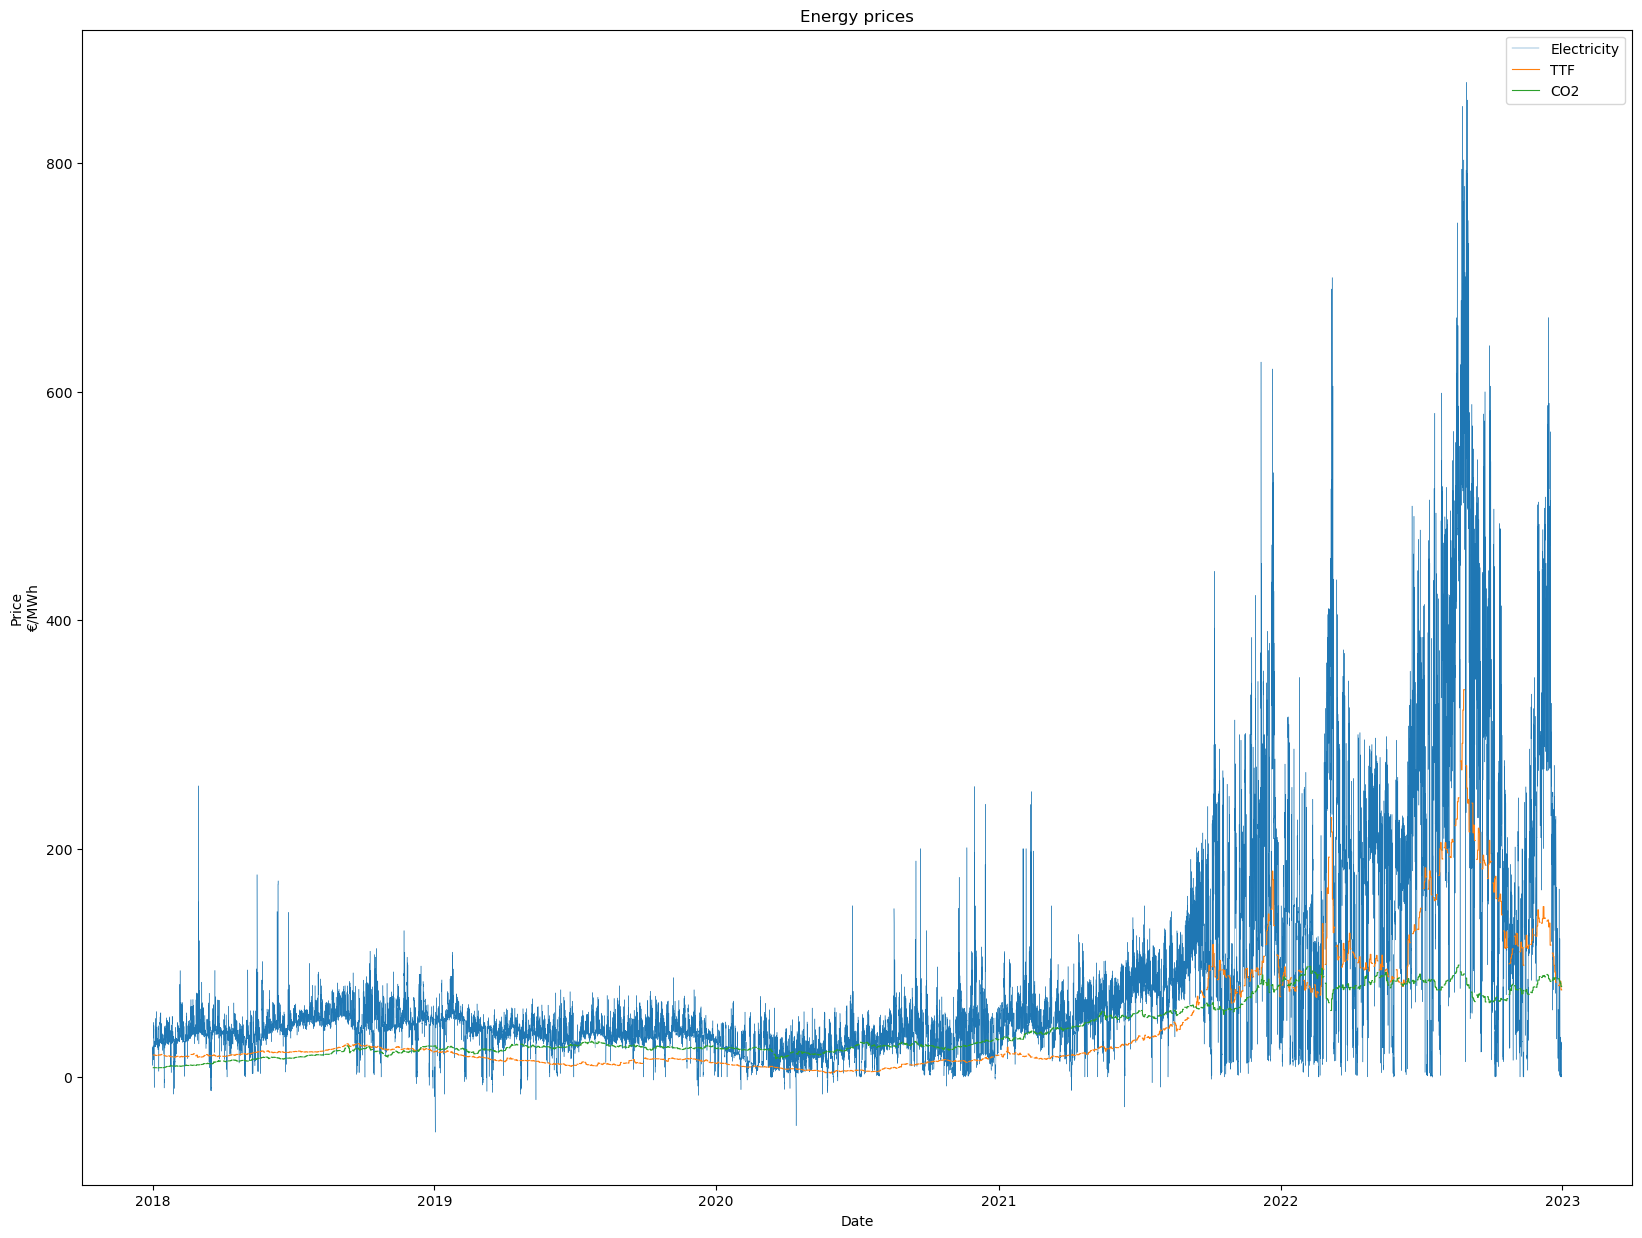

In [5]:
# Line chart of electricity price over time
plt.figure(figsize = (20,15))
plt.plot(df['Timestamp'], df['Day-ahead prices'], linestyle = '-', linewidth = 0.3, label = 'Electricity')
plt.plot(df['Timestamp'], df['TTF'], linestyle = '-', linewidth = 0.8, label = 'TTF')
plt.plot(df['Timestamp'], df['CO2'], linestyle = '-', linewidth = 0.8, label = 'CO2')
plt.legend()
plt.title('Energy prices')
plt.xlabel('Date')
plt.ylabel('Price\n€/MWh')
plt.show()

In [6]:
df2 = df.copy()

months = df['Month'].unique()
quarters = df['Quarter'].unique()
years = [2018, 2019, 2020, 2021, 2022]

In [7]:
df2.head()

Timestamp       Date  TTF  CO2  Day-ahead prices  Forecasted Load  \
0 2018-01-01 00:00:00 2018-01-01  NaN  NaN             26.33           3422.0   
1 2018-01-01 01:00:00 2018-01-01  NaN  NaN             26.43           3289.0   
2 2018-01-01 02:00:00 2018-01-01  NaN  NaN             26.10           3157.0   
3 2018-01-01 03:00:00 2018-01-01  NaN  NaN             24.70           3025.0   
4 2018-01-01 04:00:00 2018-01-01  NaN  NaN             24.74           2939.0   

   Actual Load  Solar  Wind Offshore  Wind Onshore  Wind Total  Year  Quarter  \
0       3421.0    0.0          783.0        1493.0      2276.0  2018        1   
1       3308.0    0.0          893.0        1481.0      2374.0  2018        1   
2       3118.0    0.0          755.0        1430.0      2185.0  2018        1   
3       3018.0    0.0          747.0        1458.0      2205.0  2018        1   
4       2916.0    0.0          886.0        1472.0      2358.0  2018        1   

   Month  Day  Hour  
0      1    1     0  
1      1    1     1  
2      1    1     2  
3      1    1     3  
4      1    1     4

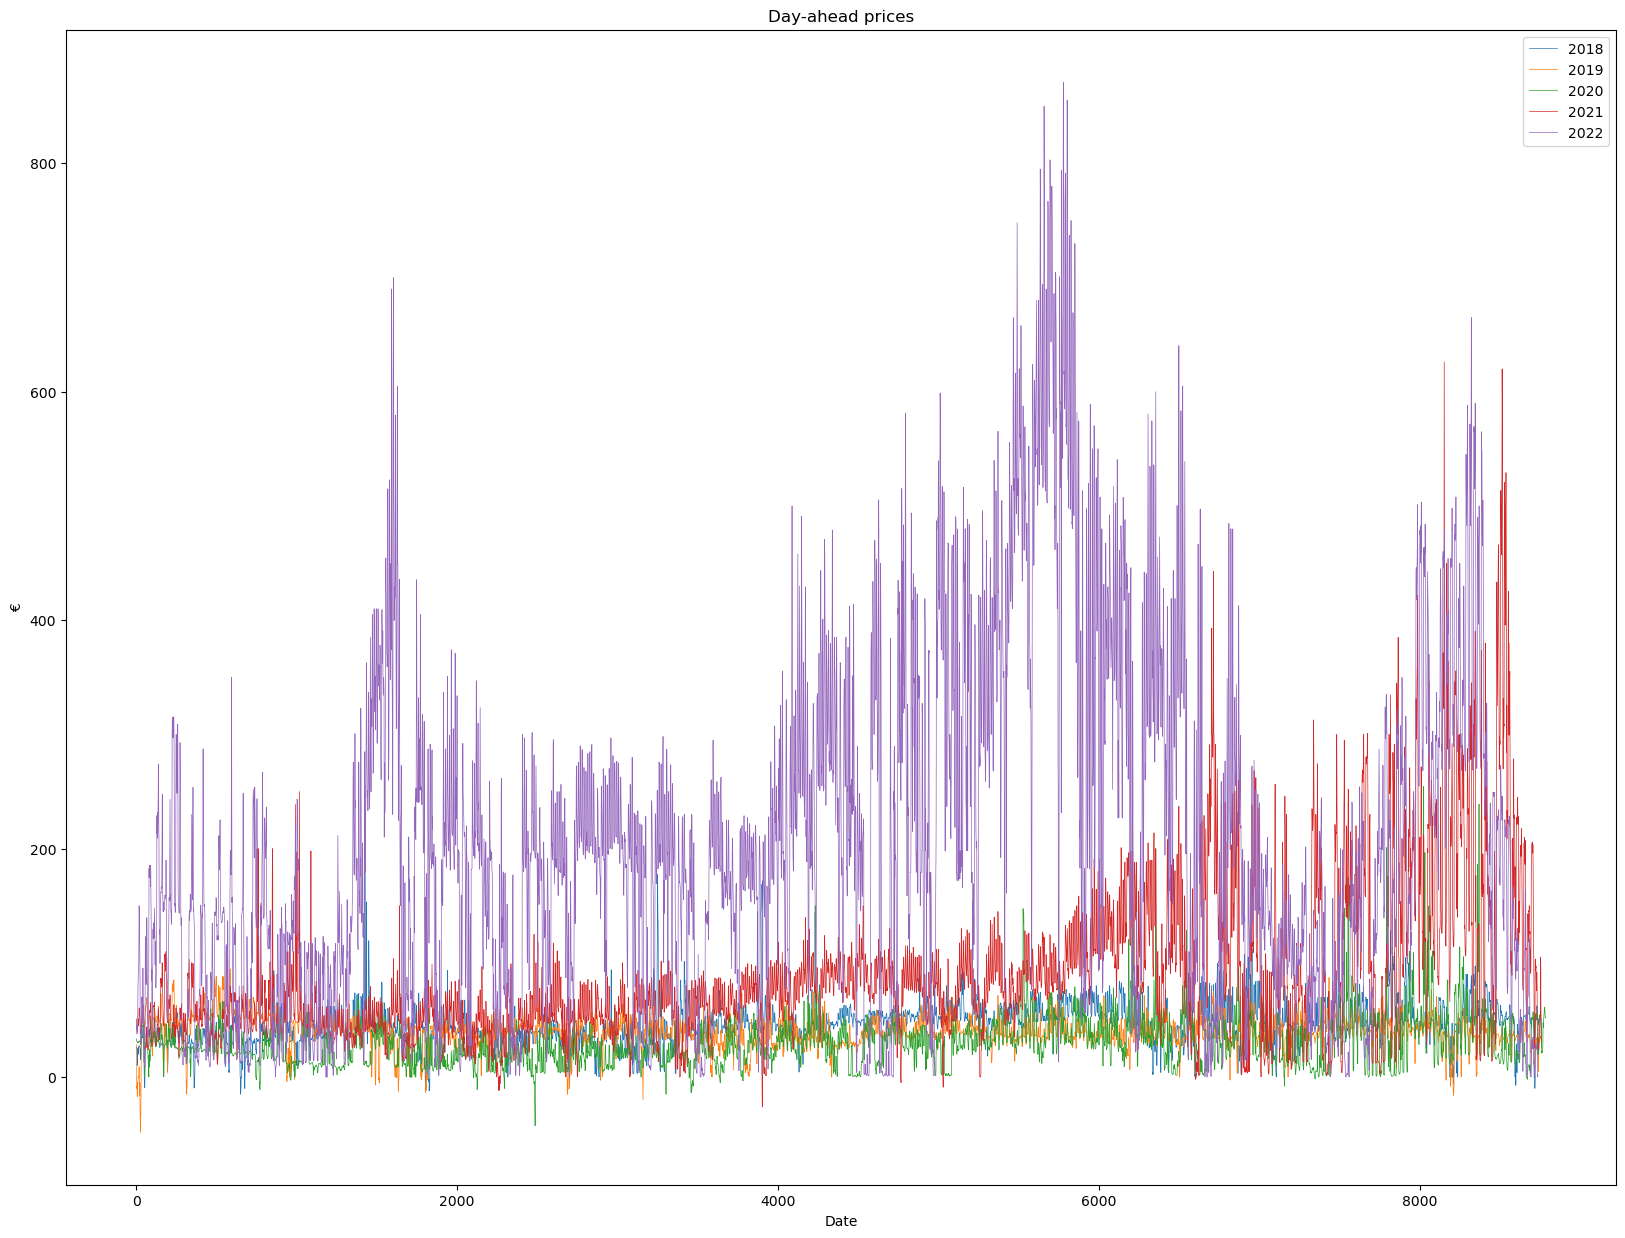

In [8]:
plt.figure(figsize = (20,15))
for yr in years:
    plt.plot(df2[df2['Year'] == yr].reset_index()['Day-ahead prices'], linewidth = 0.5, label = yr)
plt.title('Day-ahead prices')
plt.xlabel('Date')
plt.ylabel('€')
plt.legend()
plt.show()

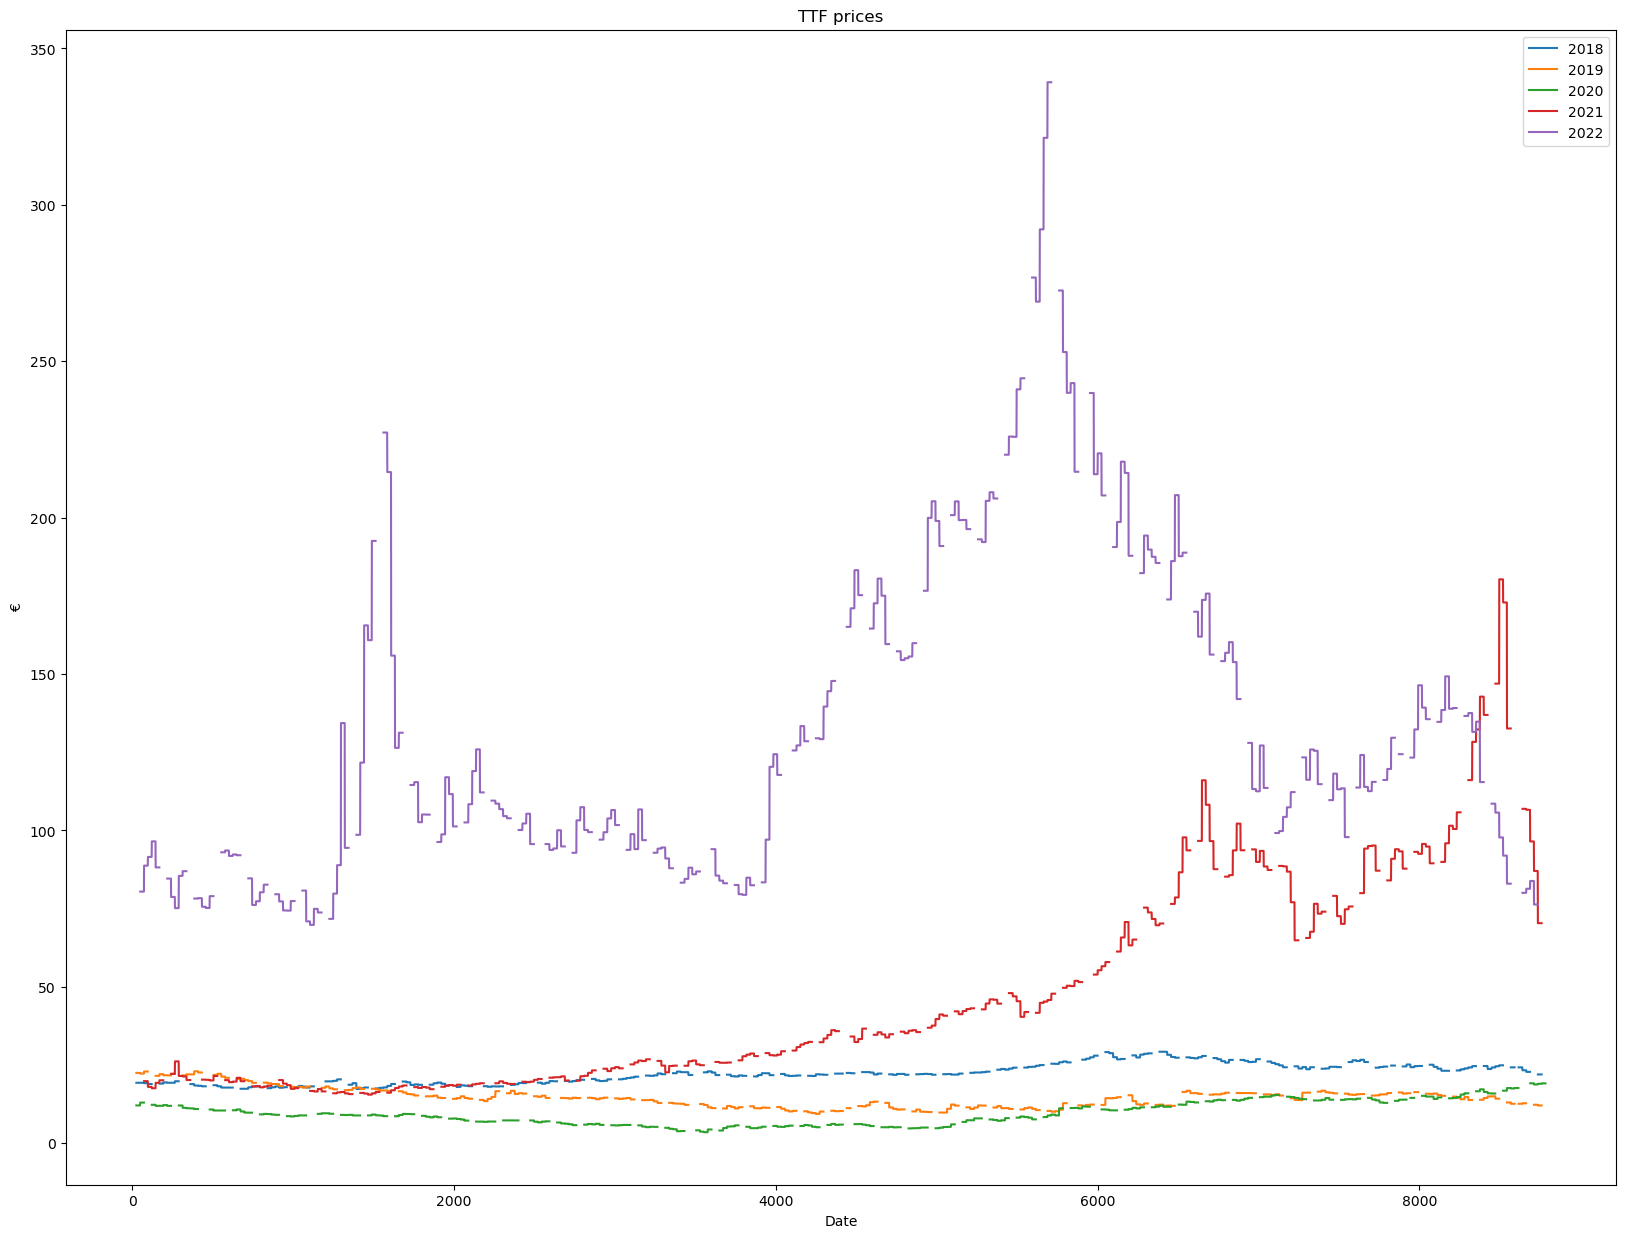

In [9]:
plt.figure(figsize = (20,15))
for yr in years:
    plt.plot(df2[df2['Year'] == yr].reset_index()['TTF'], label = yr)
plt.title('TTF prices')
plt.xlabel('Date')
plt.ylabel('€')
plt.legend()
plt.show()

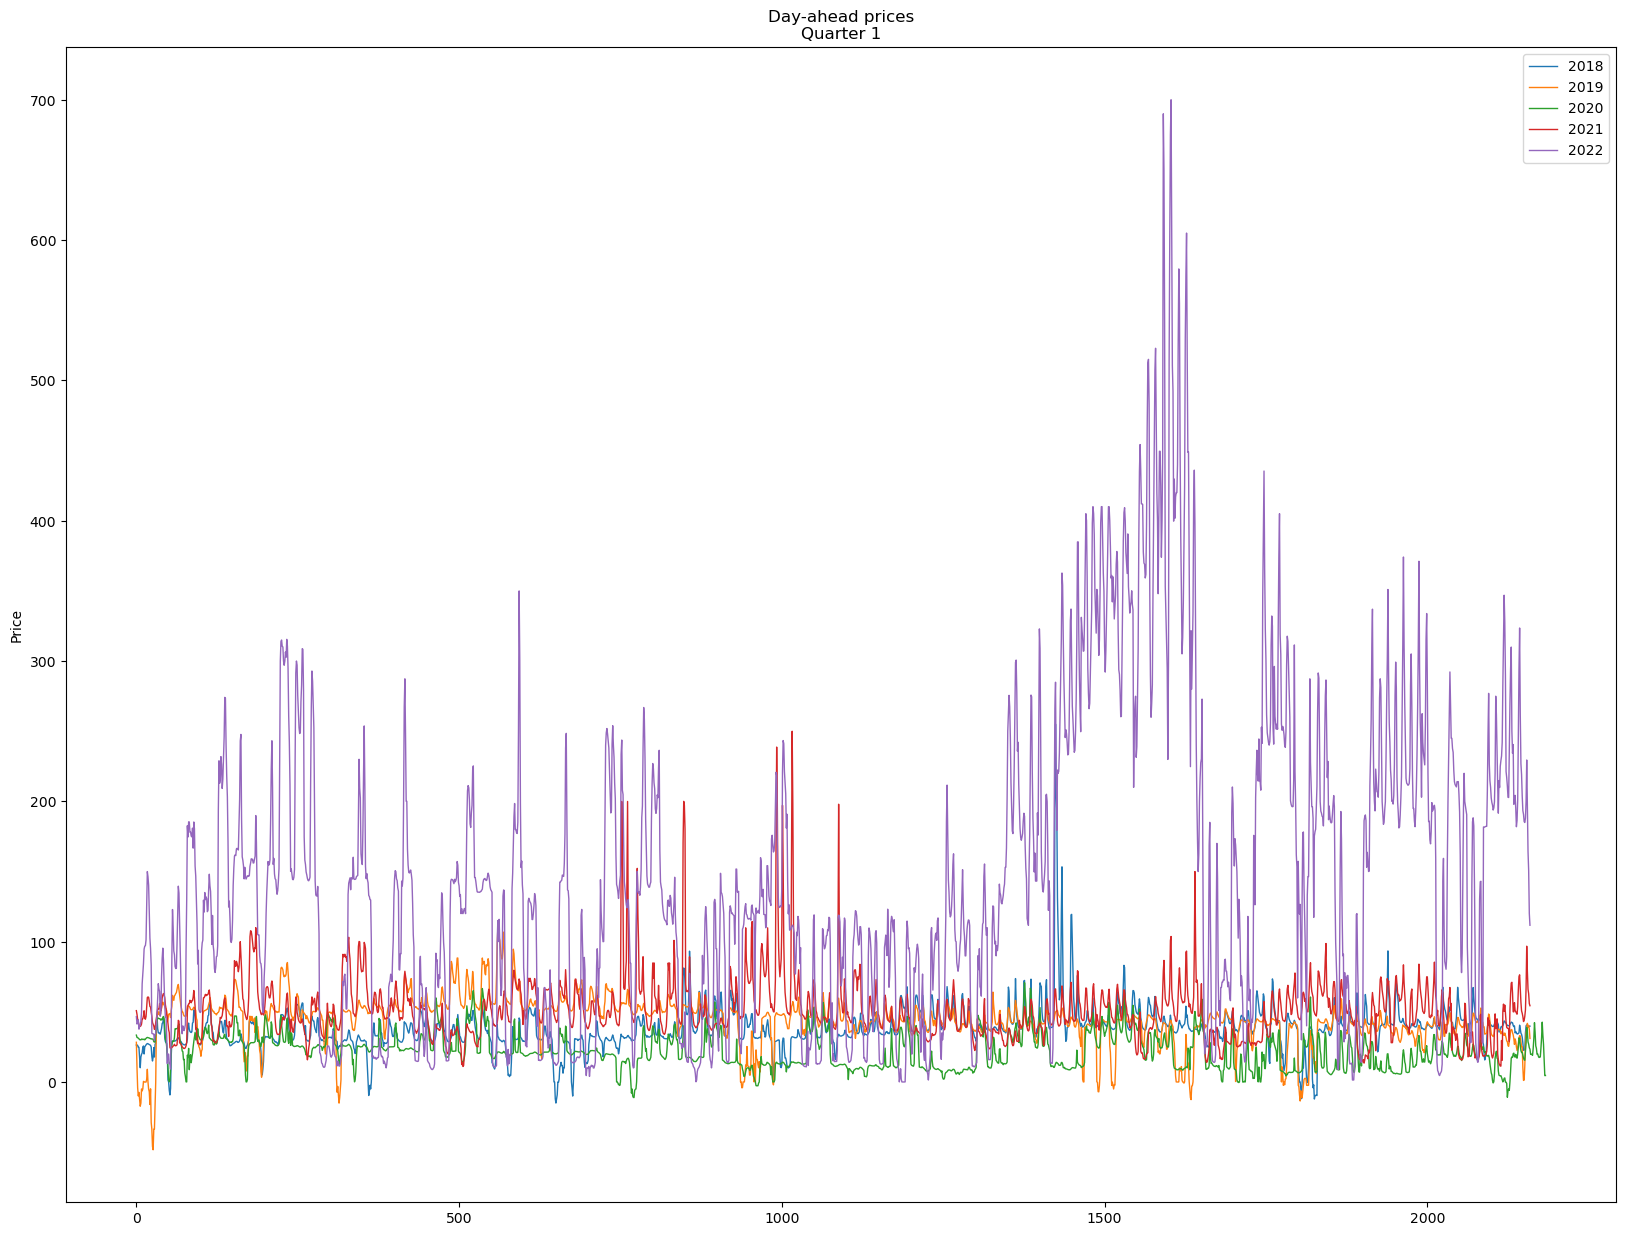

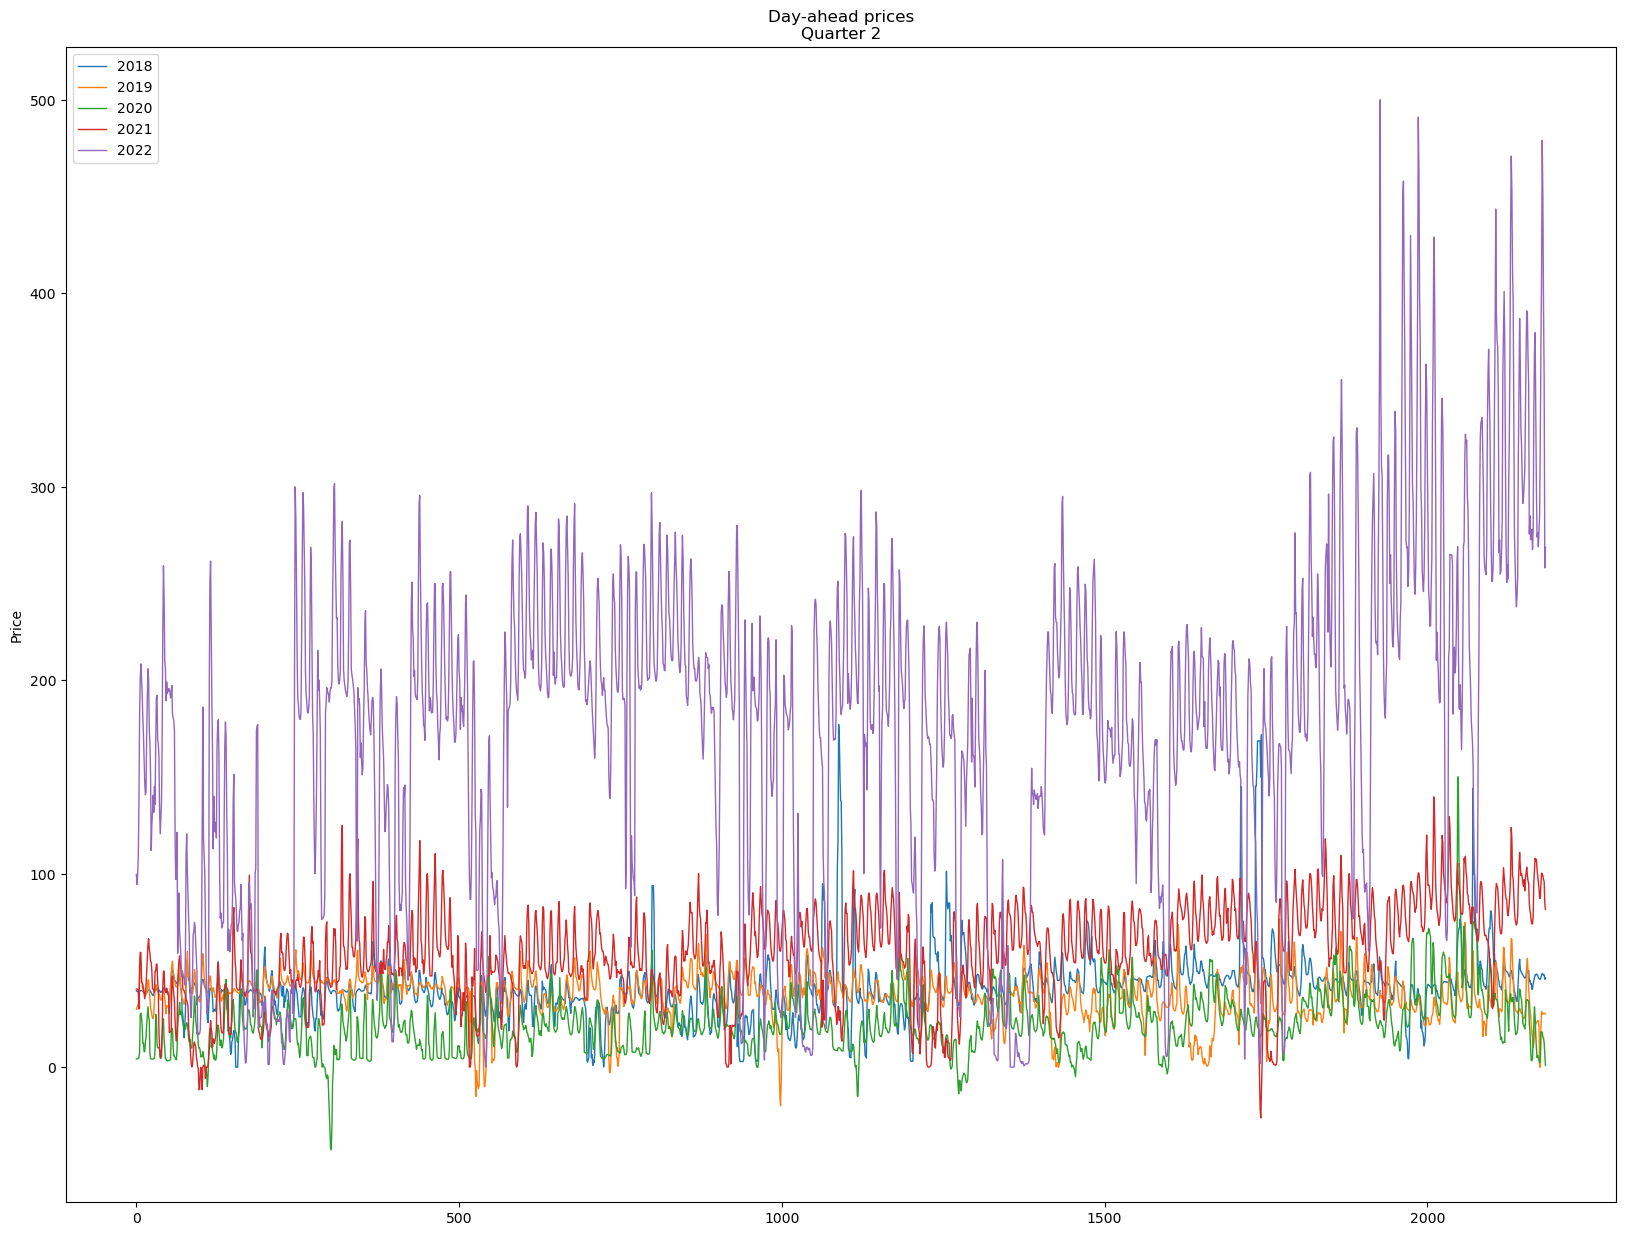

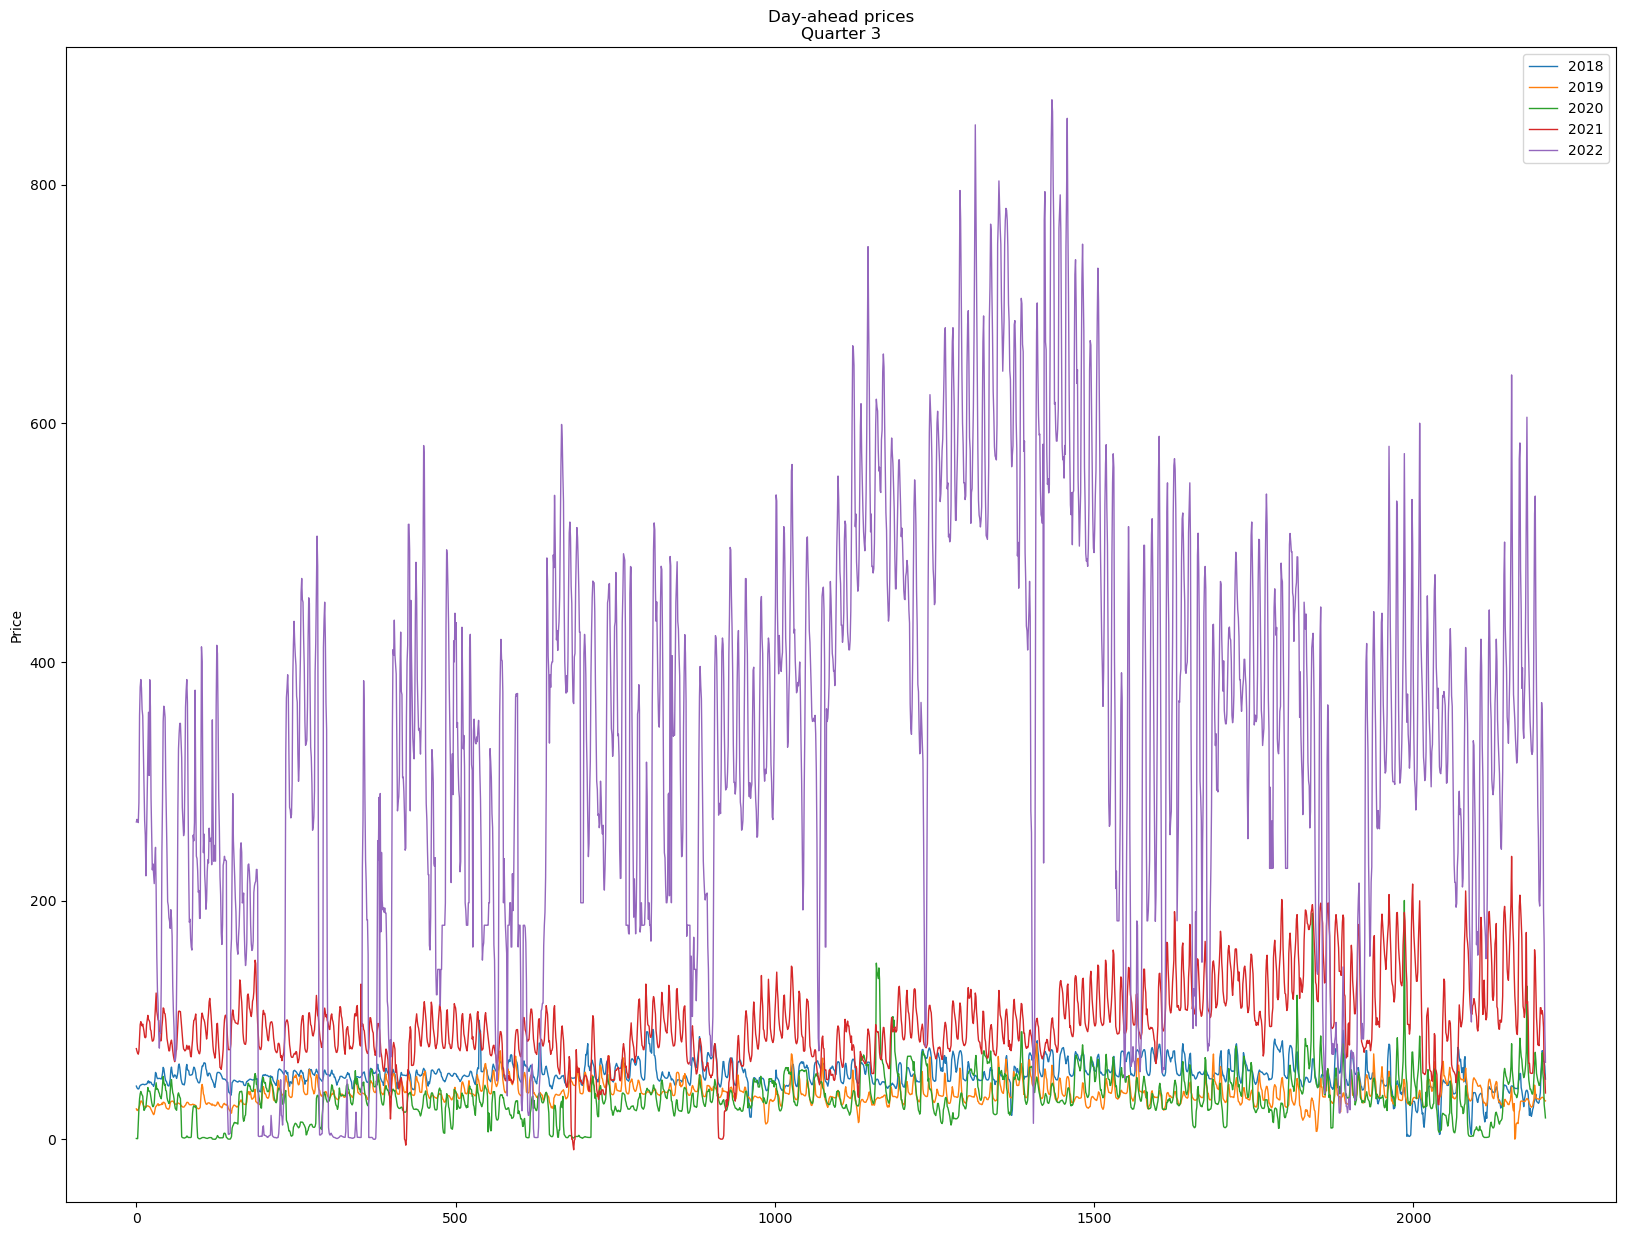

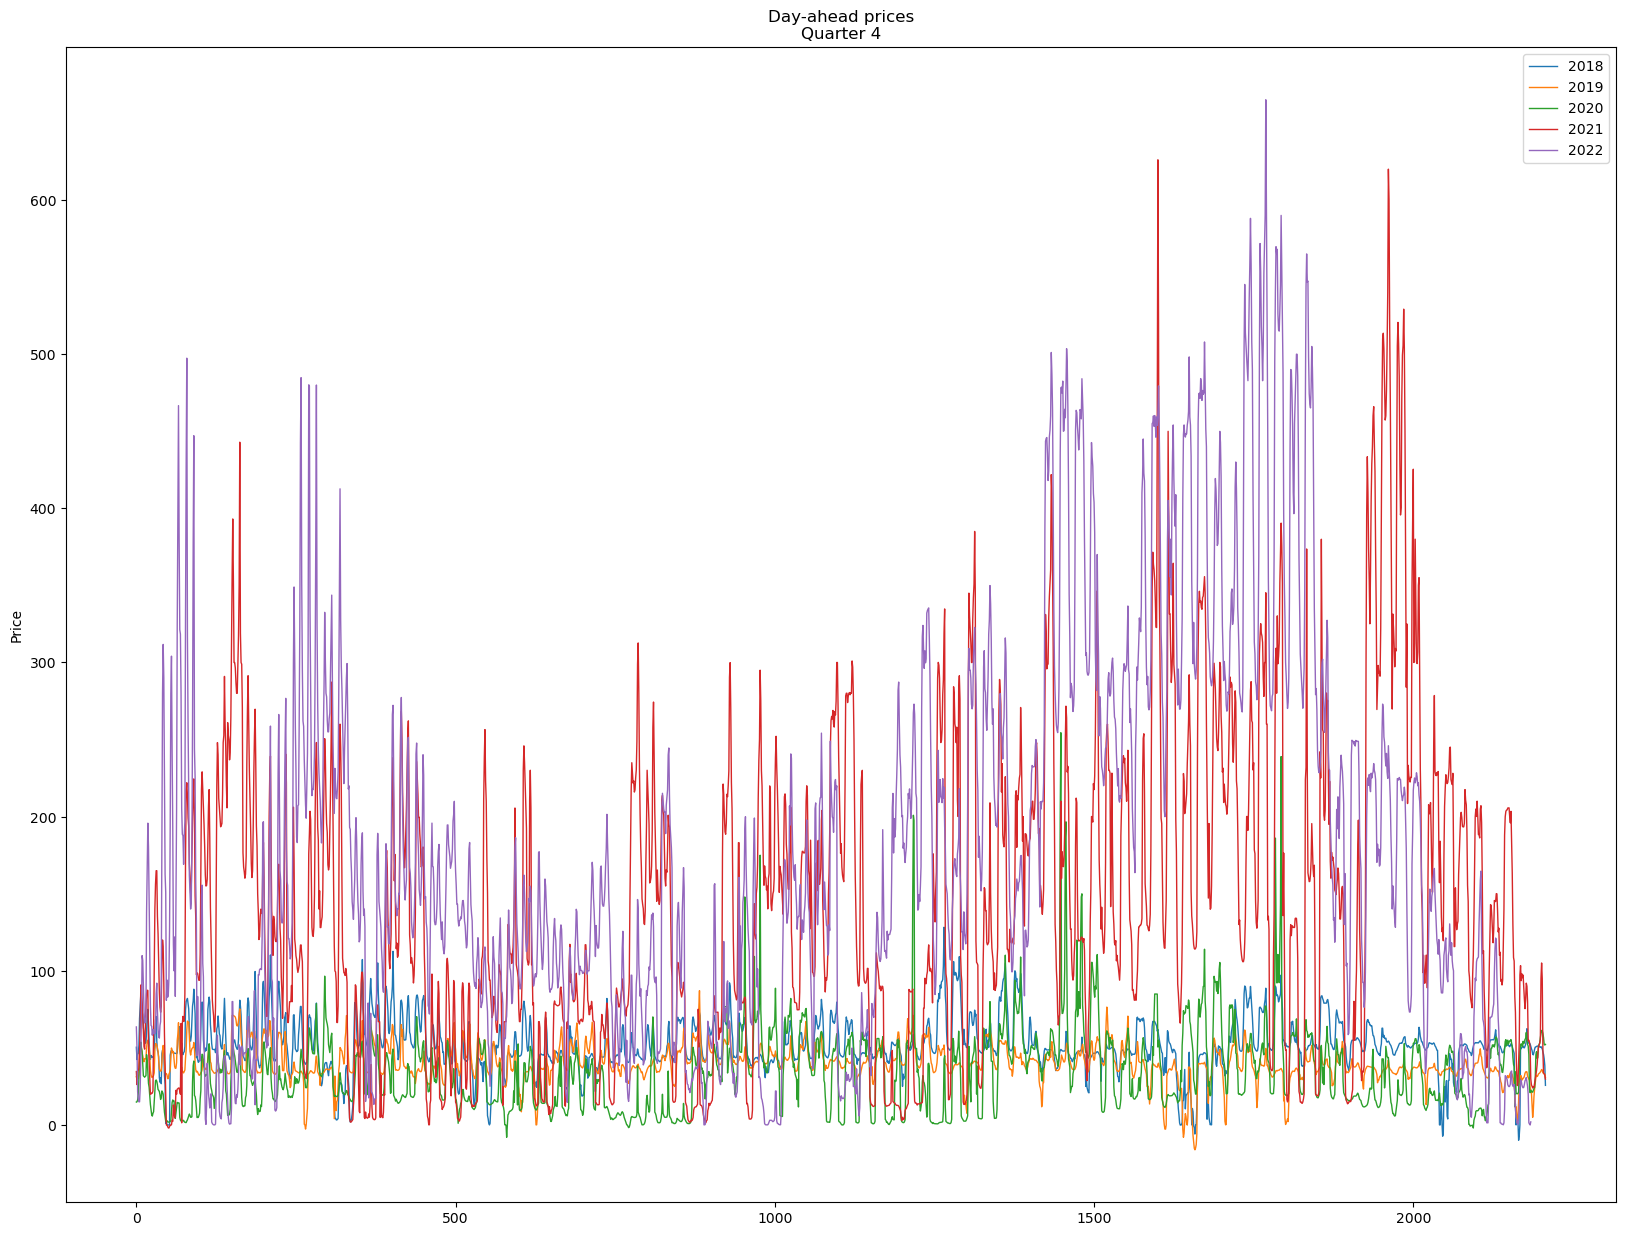

In [10]:
for q in quarters:
    plt.figure(figsize = (20,15))
    for y in years:
        temp = df2[(df2['Year'] == y) & (df2['Quarter'] == q)].reset_index()
        plt.plot(temp['Day-ahead prices'], linestyle = '-', linewidth = 1, label = y)
#         plt.plot(temp['Date'], temp['TTF'], linestyle = '-', linewidth = 0.8, label = 'TTF')
#         plt.plot(temp['Date'], temp['CO2'], linestyle = '-', linewidth = 0.8, label = 'CO2')
    plt.legend()
    plt.title('Day-ahead prices\nQuarter '+str(q))
    plt.ylabel('Price')
    plt.show()

In [11]:
cols = ['Day-ahead prices', 'TTF', 'CO2']
df3 = df2.groupby(by = 'Date')[cols].mean()
df3.reset_index(inplace = True)
df3.head()

Date  Day-ahead prices     TTF   CO2
0 2018-01-01         23.972500     NaN   NaN
1 2018-01-02         32.287500  19.320  8.22
2 2018-01-03         21.706667  19.325  8.24
3 2018-01-04         35.558750  19.200  8.18
4 2018-01-05         38.096250  18.915  8.19

In [12]:
df2['Date'].dtype

dtype('<M8[ns]')

In [13]:
df3 = get_dt_info(df3, 'Date', yr = True, qt = True, mo = True, day = True)

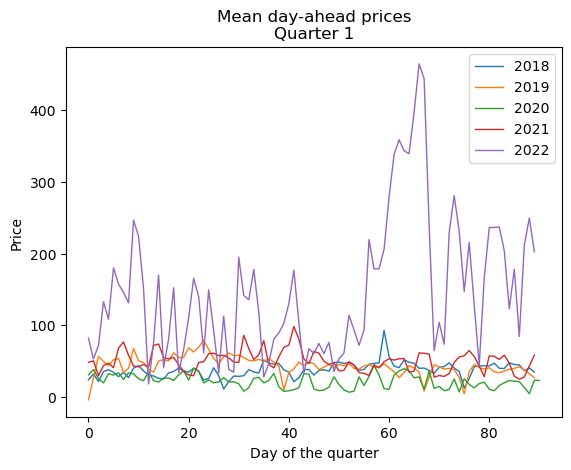

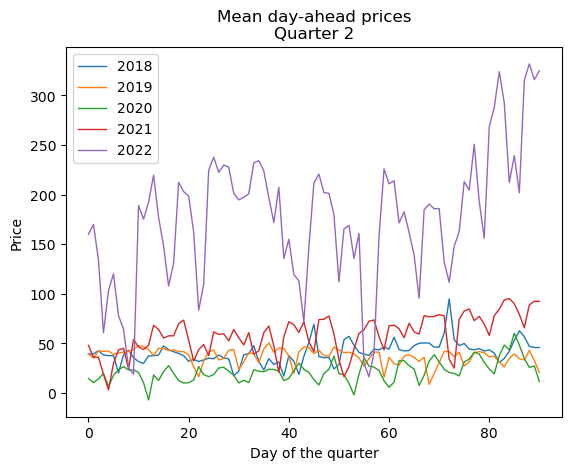

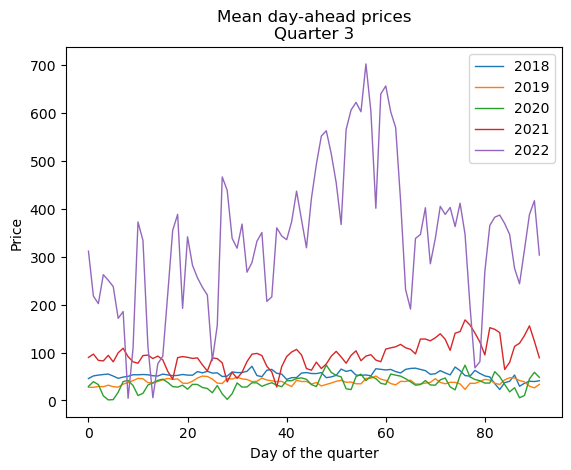

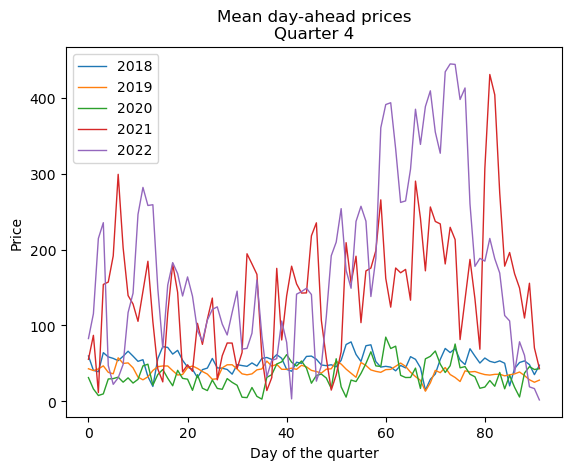

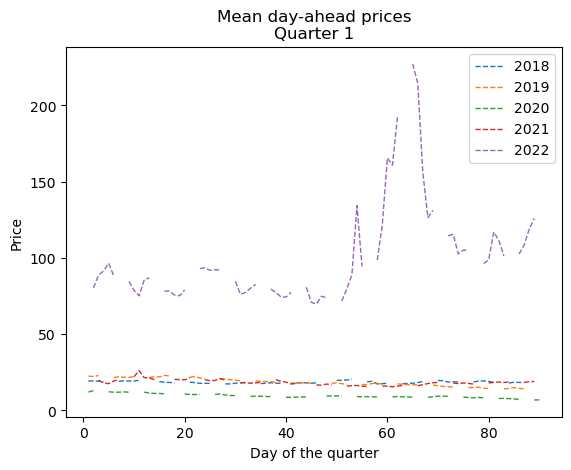

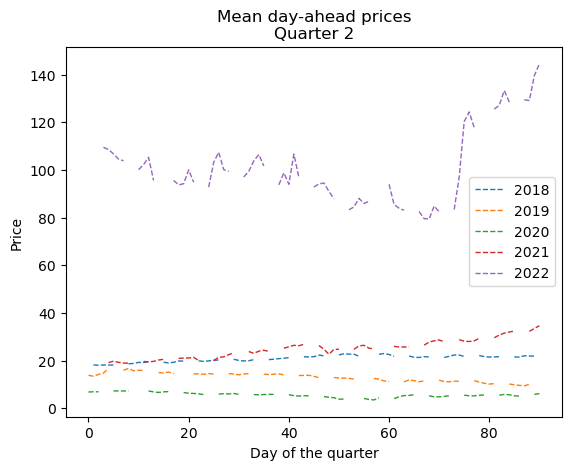

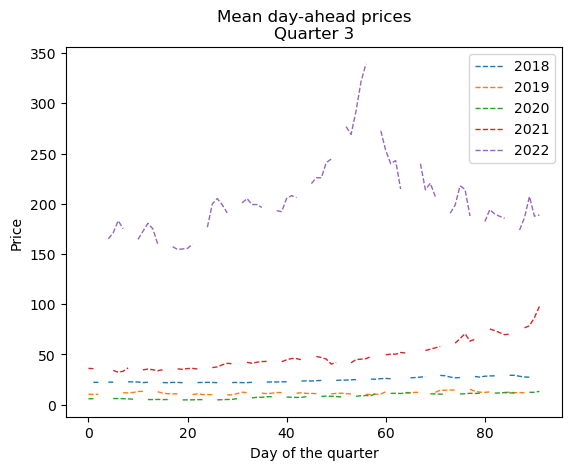

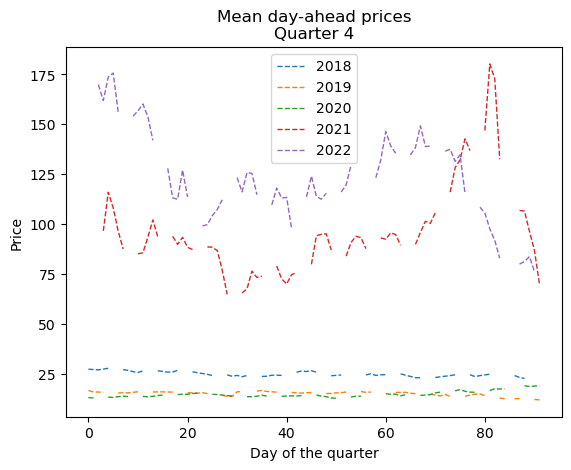

In [14]:
for q in quarters:
    for y in years:
        temp = df3[(df3['Year'] == y) & (df3['Quarter'] == q)].reset_index()
        plt.plot(temp['Day-ahead prices'], linestyle = '-', linewidth = 1, label = y)
#         plt.plot(temp['TTF'], linestyle = '--', linewidth = 1, label = y)
    plt.legend()
    plt.title('Mean day-ahead prices\nQuarter '+str(q))
    plt.xlabel('Day of the quarter')
    plt.ylabel('Price')
    plt.show()
    
for q in quarters:
    for y in years:
        temp = df3[(df3['Year'] == y) & (df3['Quarter'] == q)].reset_index()
#         plt.plot(temp['Day-ahead prices'], linestyle = '-', linewidth = 1, label = y)
        plt.plot(temp['TTF'], linestyle = '--', linewidth = 1, label = y)
    plt.legend()
    plt.title('Mean day-ahead prices\nQuarter '+str(q))
    plt.xlabel('Day of the quarter')
    plt.ylabel('Price')
    plt.show()

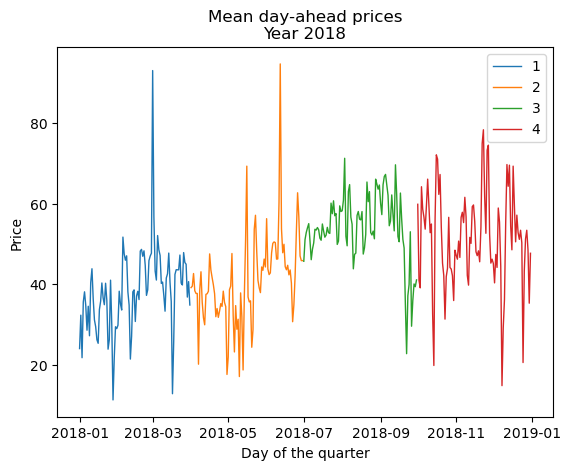

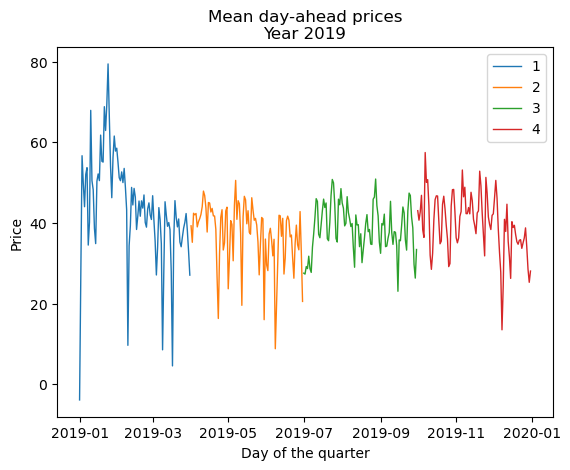

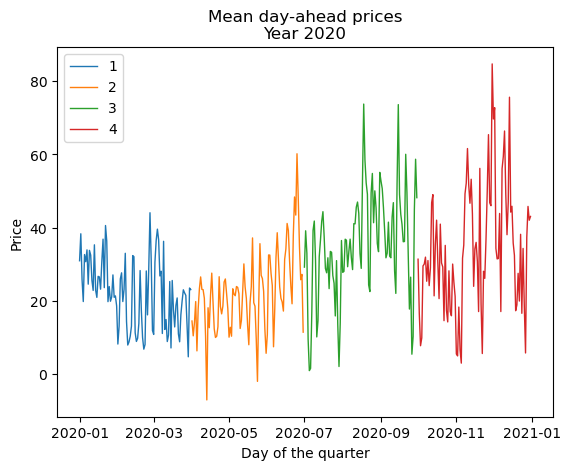

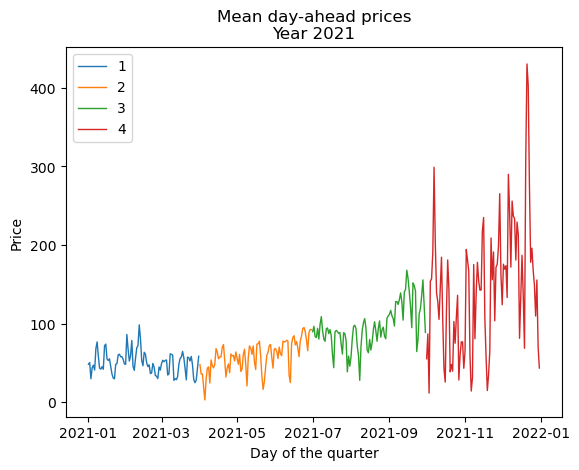

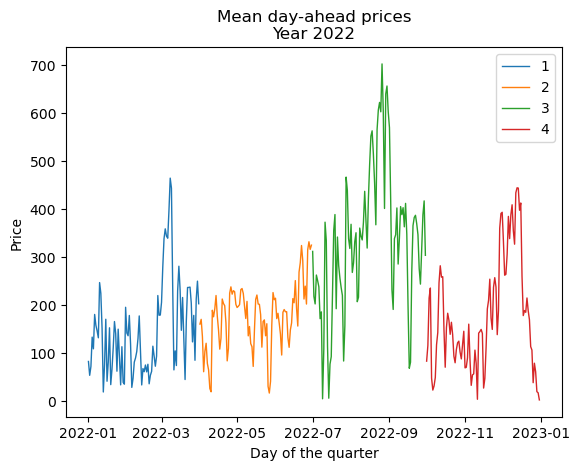

In [15]:
for y in years:
    for q in quarters:
        temp = df3[(df3['Year'] == y) & (df3['Quarter'] == q)].reset_index()
        plt.plot(temp['Date'], temp['Day-ahead prices'], linestyle = '-', linewidth = 1, label = q)
    plt.legend()
    plt.title('Mean day-ahead prices\nYear '+str(y))
    plt.xlabel('Day of the quarter')
    plt.ylabel('Price')
    plt.show()

In [16]:
df['Day-ahead prices'].notna().count()

43824

In [17]:
df[df['Day-ahead prices'] < 0]['Day-ahead prices'].count()

250

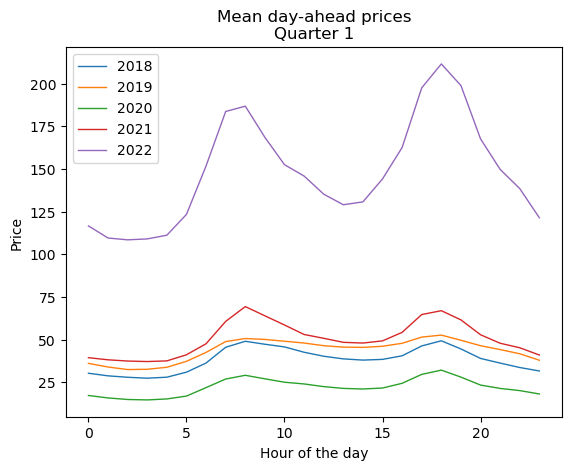

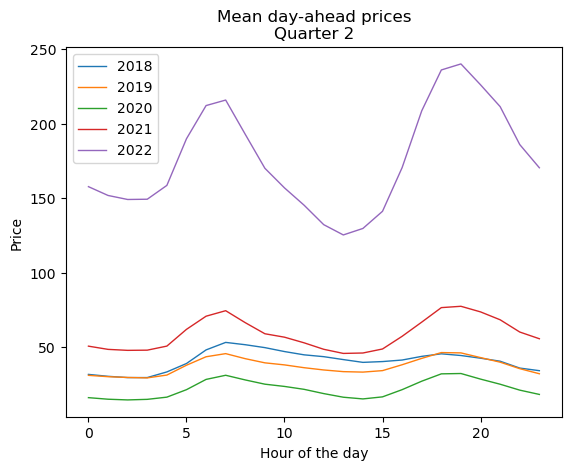

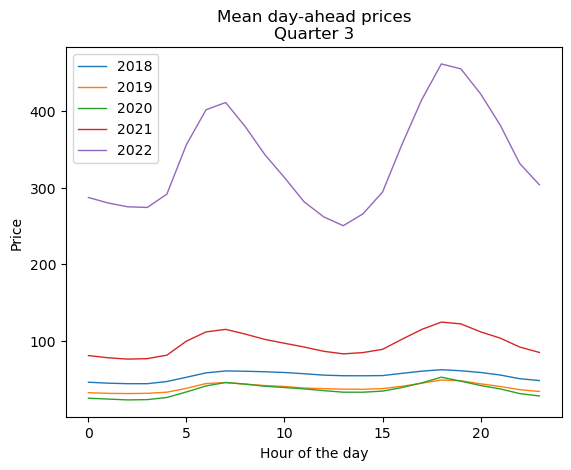

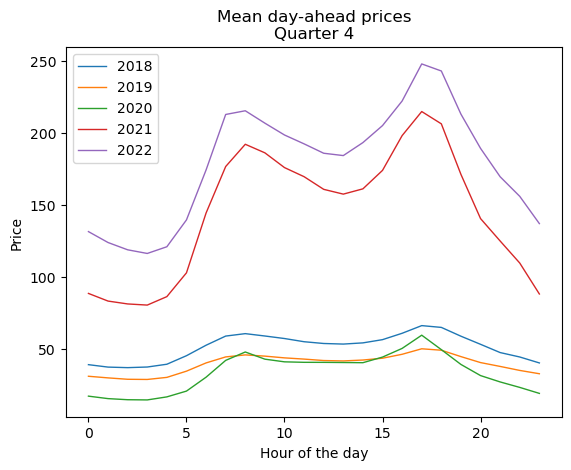

In [18]:
for q in quarters:
    for y in years:
        temp = df2[(df2['Year'] == y) & (df2['Quarter'] == q)].reset_index()
        temp = temp.groupby('Hour').mean(numeric_only = True)
        plt.plot(temp['Day-ahead prices'], linestyle = '-', linewidth = 1, label = y)
    plt.legend()
    plt.title('Mean day-ahead prices\nQuarter '+str(q))
    plt.xlabel('Hour of the day')
    plt.ylabel('Price')
    plt.show()

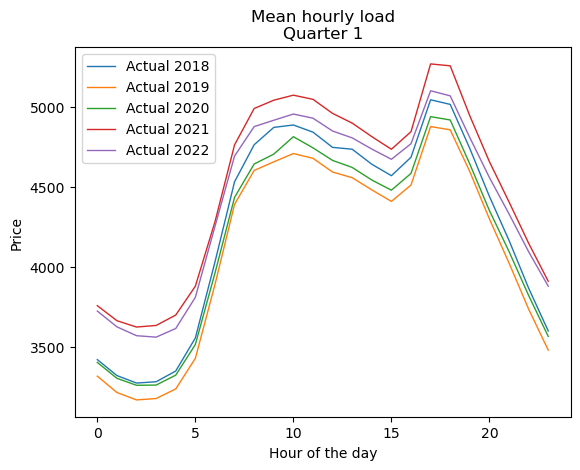

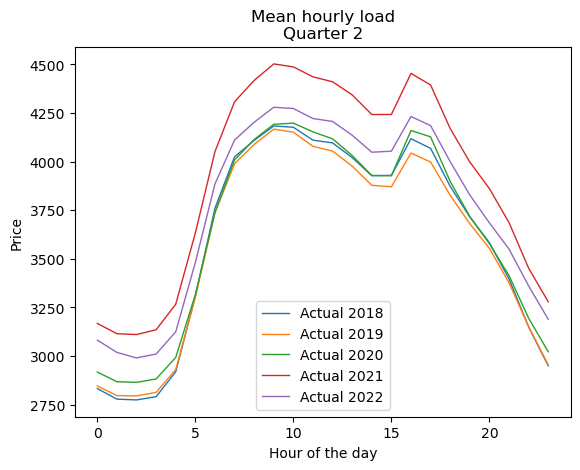

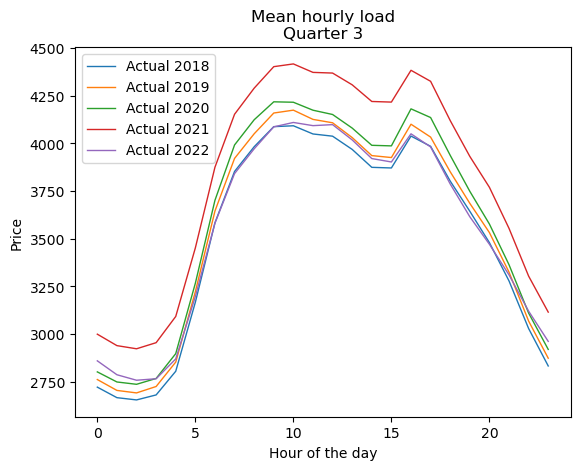

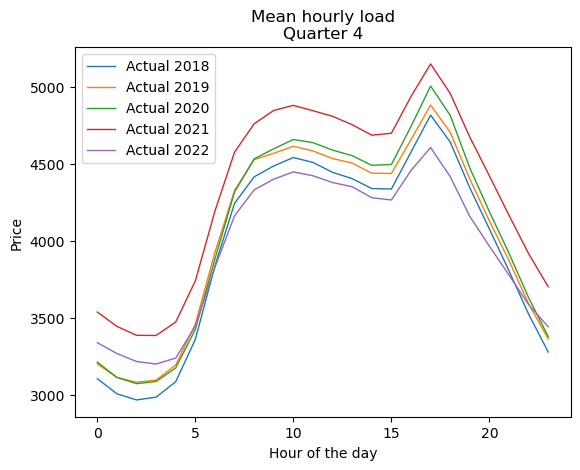

In [19]:
for q in quarters:
    for y in years:
        temp = df2[(df2['Year'] == y) & (df2['Quarter'] == q)].reset_index()
        temp = temp.groupby('Hour').mean(numeric_only = True)
        plt.plot(temp['Actual Load'], linestyle = '-', linewidth = 1, label = 'Actual ' + str(y))
#         plt.plot(temp['Forecasted Load'], linestyle = '--', linewidth = 1, label = 'Forecasted' + str(y))
    plt.legend()
    plt.title('Mean hourly load\nQuarter '+str(q))
    plt.xlabel('Hour of the day')
    plt.ylabel('Price')
    plt.show()

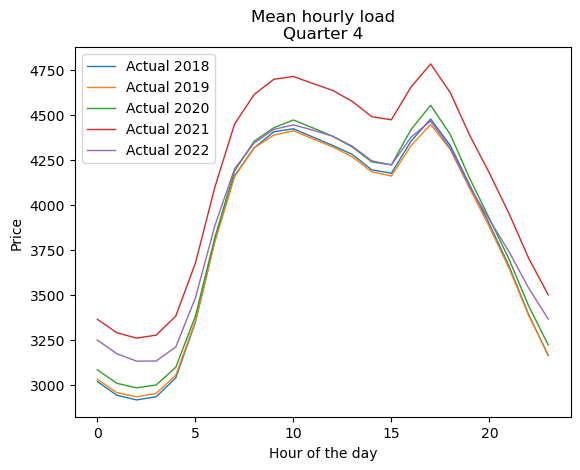

In [20]:
for y in years:
    temp = df2[(df2['Year'] == y)].reset_index()
    temp = temp.groupby('Hour').mean(numeric_only = True)
    plt.plot(temp['Actual Load'], linestyle = '-', linewidth = 1, label = 'Actual ' + str(y))
#     plt.plot(temp['Forecasted Load'], linestyle = '--', linewidth = 1, label = 'Forecasted' + str(y))
plt.legend()
plt.title('Mean hourly load\nQuarter '+str(q))
plt.xlabel('Hour of the day')
plt.ylabel('Price')
plt.show()

In [32]:
df2 = get_dt_info(df2, 'Date', w = True)

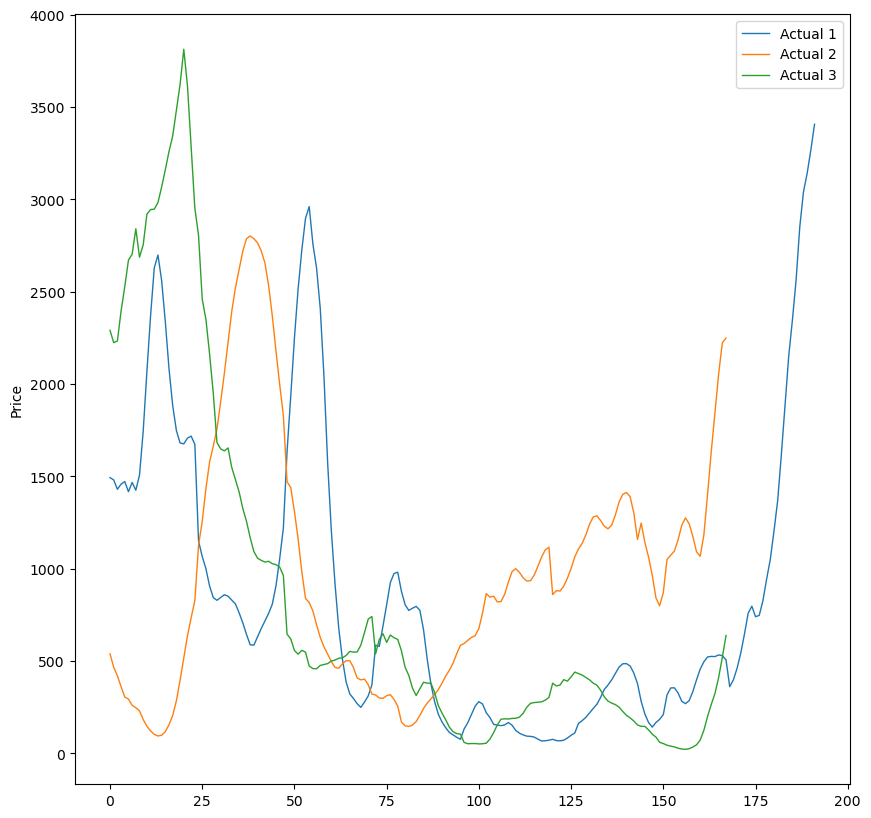

In [38]:
plt.figure(figsize=(10,10))
for w in range(1,4):
    temp = df2[(df2['Week'] == w) & (df['Year']  == 2018)].reset_index()
#     temp = temp.groupby('Hour').mean(numeric_only = True)
    plt.plot(temp['Wind Onshore'], linestyle = '-', linewidth = 1, label = 'Actual ' + str(w))
#     plt.plot(temp['Forecasted Load'], linestyle = '--', linewidth = 1, label = 'Forecasted' + str(y))
plt.legend()
# plt.title('Mean hourly load\nQuarter '+str(q))
# plt.xlabel('Hour of the day')
plt.ylabel('Price')
plt.show()

In [21]:
df4 = df2.set_index('Timestamp')

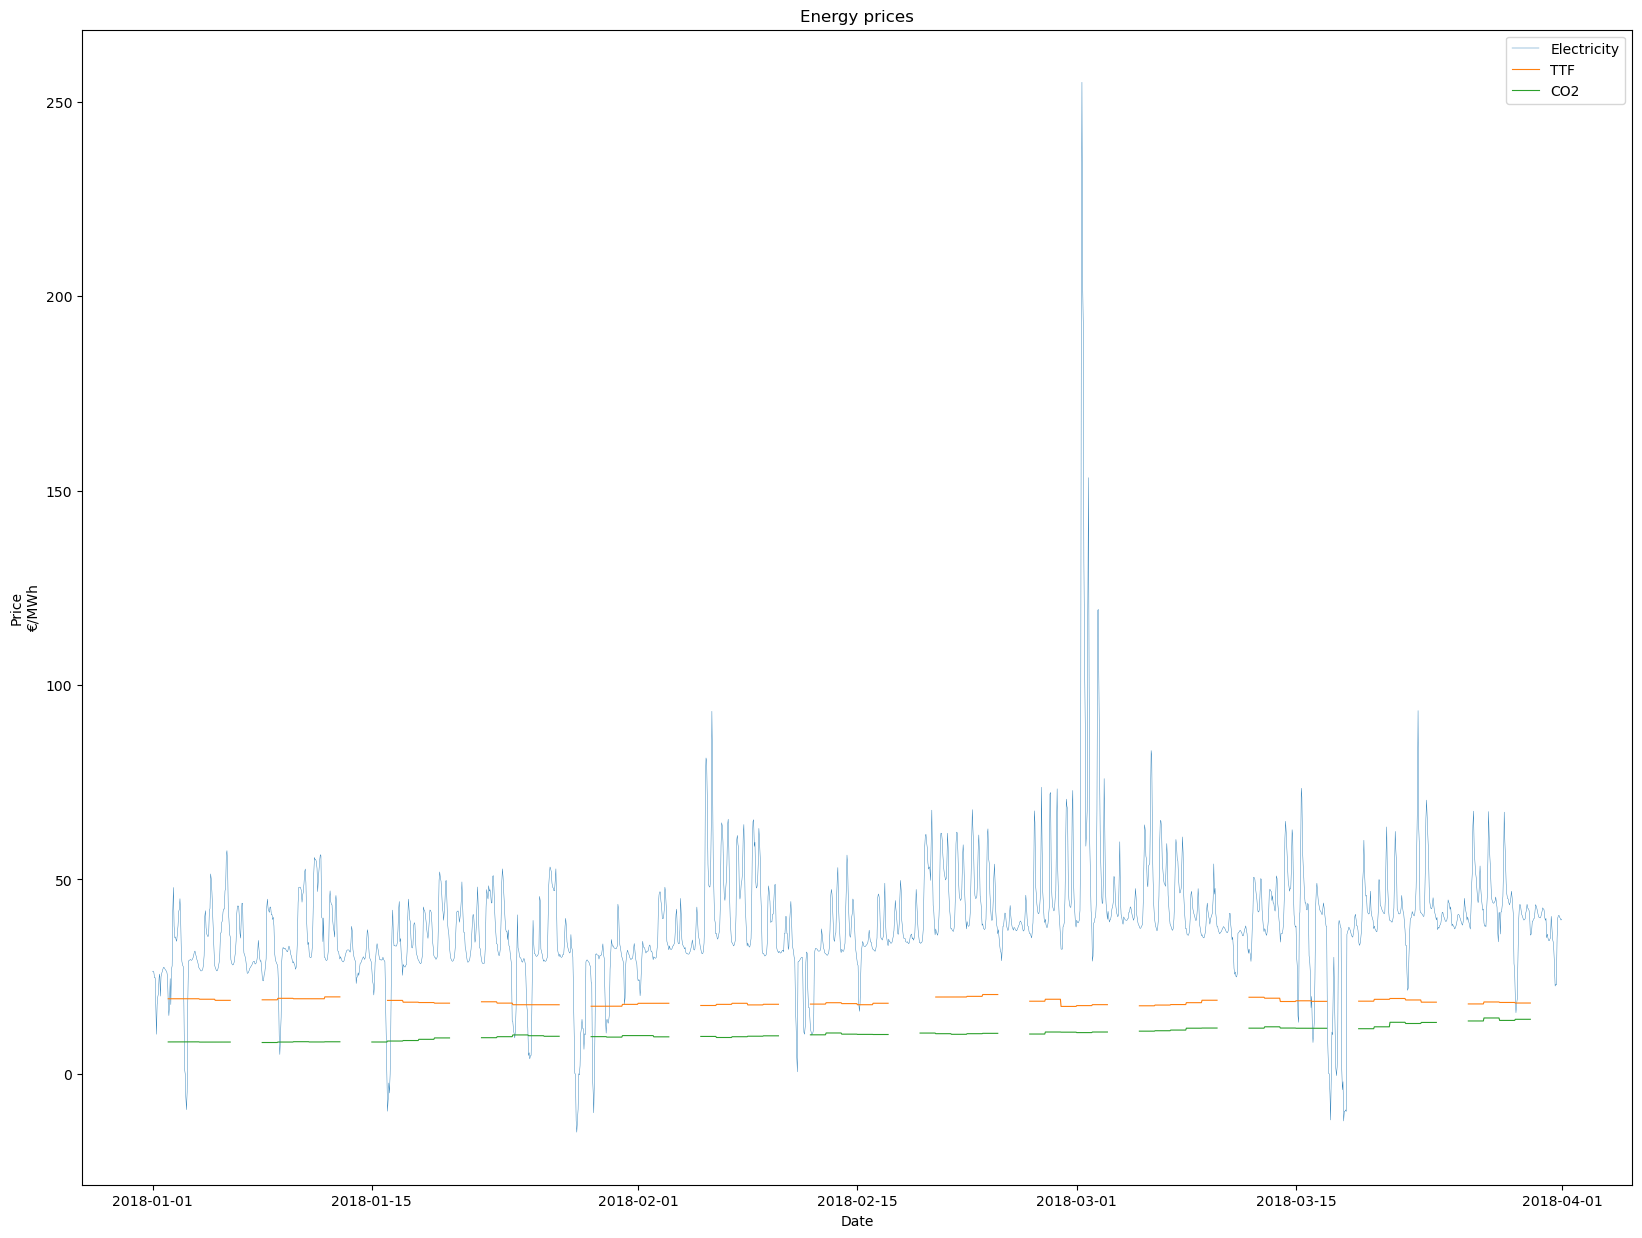

In [22]:
# Line chart of electricity price over time
plt.figure(figsize = (20,15))
plt.plot(df4.loc['2018-01':'2018-03']['Day-ahead prices'], linestyle = '-', linewidth = 0.3, label = 'Electricity')
plt.plot(df4.loc['2018-01':'2018-03']['TTF'], linestyle = '-', linewidth = 0.8, label = 'TTF')
plt.plot(df4.loc['2018-01':'2018-03']['CO2'], linestyle = '-', linewidth = 0.8, label = 'CO2')
# plt.plot(df2.loc['2018-01':'2018-03'].index, df2.loc['2018-01':'2018-03']['Day-ahead prices'], linestyle = '-', linewidth = 0.3, label = 'Electricity')
# plt.plot(df2.loc['2018-01':'2018-03'].index, df2.loc['2018-01':'2018-03']['TTF'], linestyle = '-', linewidth = 0.8, label = 'TTF')
# plt.plot(df2.loc['2018-01':'2018-03'].index, df2.loc['2018-01':'2018-03']['CO2'], linestyle = '-', linewidth = 0.8, label = 'CO2')
plt.legend()
plt.title('Energy prices')
plt.xlabel('Date')
plt.ylabel('Price\n€/MWh')
plt.show()

In [ ]:
df['diff1'] = df['Day-ahead prices'].diff(periods = 1)
tsaplots.plot_acf(df['diff1'].dropna(), lags = 168)

In [ ]:
df['diff24'] = df['Day-ahead prices'].diff(periods = 24)
tsaplots.plot_acf(df['diff24'].dropna(), lags = 24)

In [ ]:
tsaplots.plot_acf(df['Day-ahead prices'].dropna(), lags = 48)
# tsaplots.plot_pacf(df['Day-ahead prices'].dropna(), lags = 48)

In [ ]:
df_log = df[df['Day-ahead prices'] > 0].copy()
df_log['Day-ahead prices log'] = np.log(df_log['Day-ahead prices'])
tsaplots.plot_acf(df_log['Day-ahead prices log'].dropna(), lags = 48)

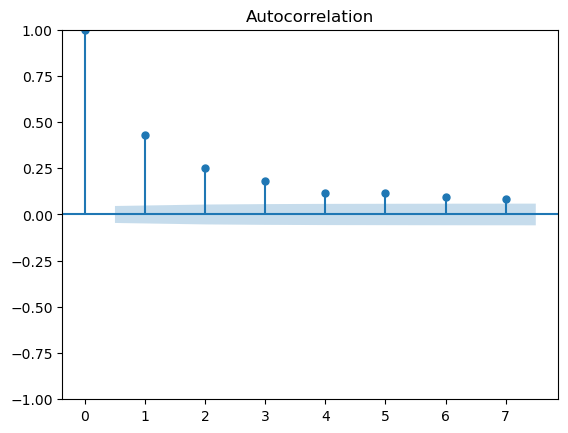

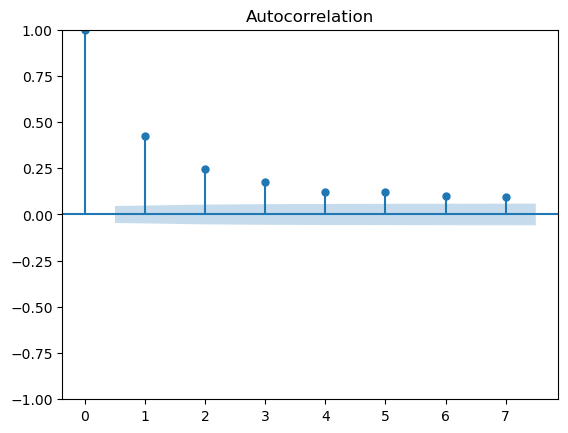

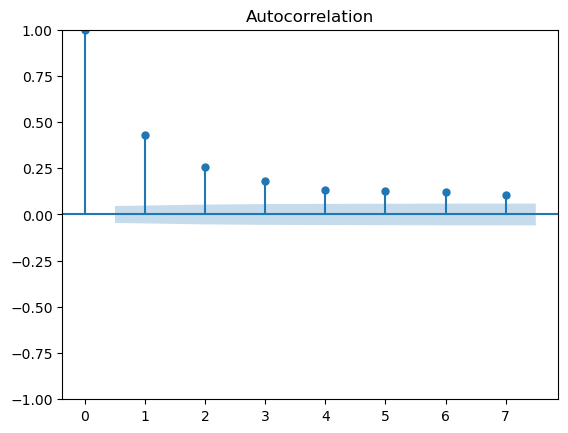

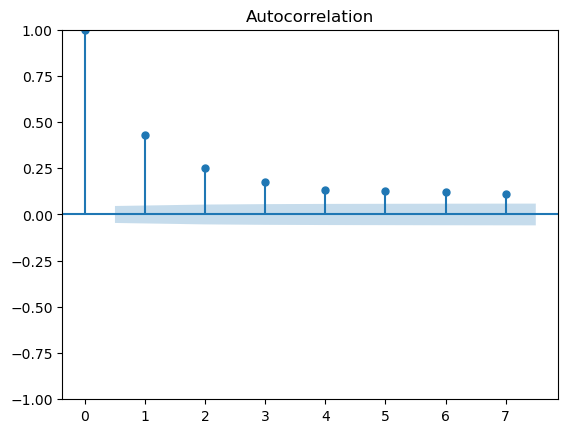

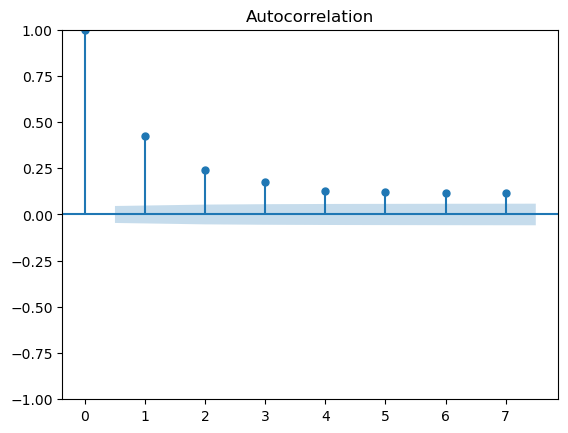

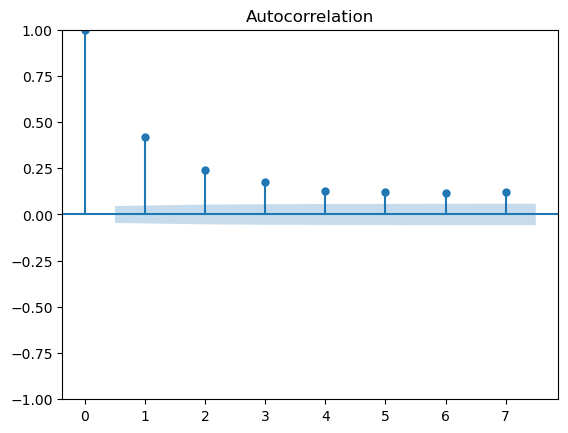

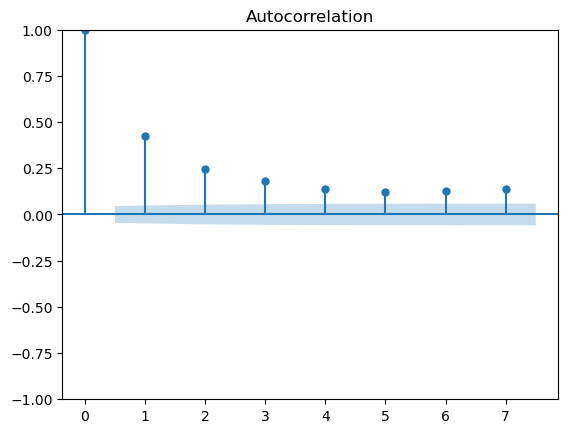

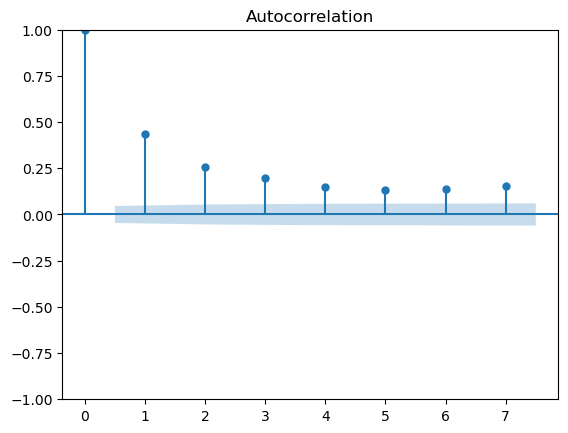

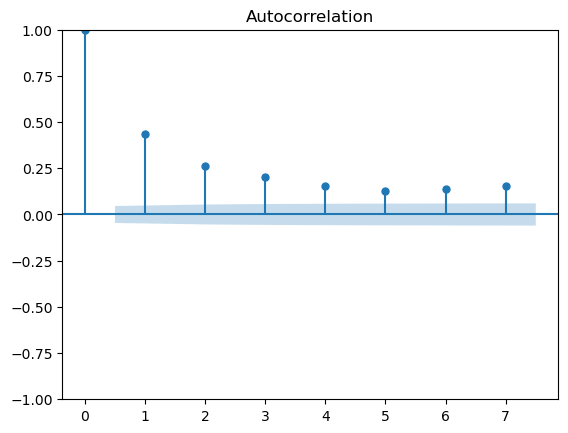

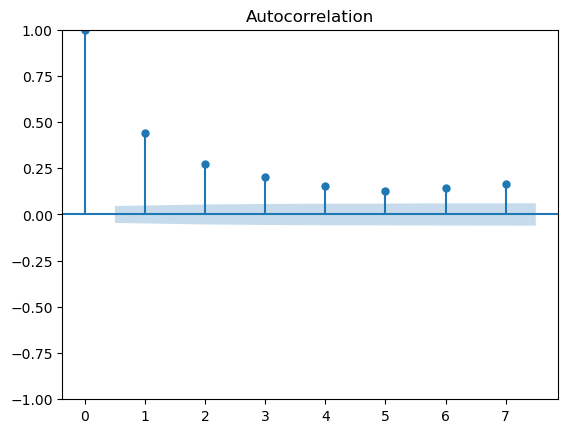

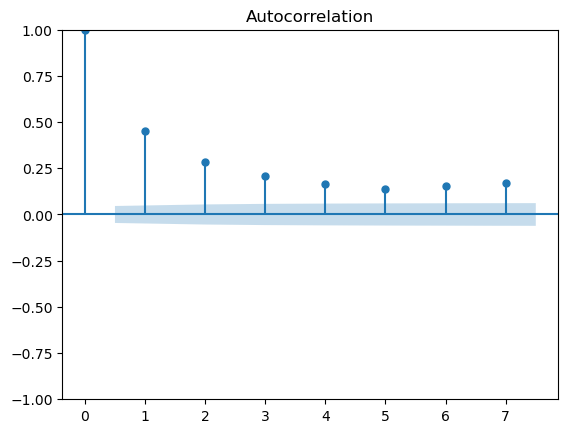

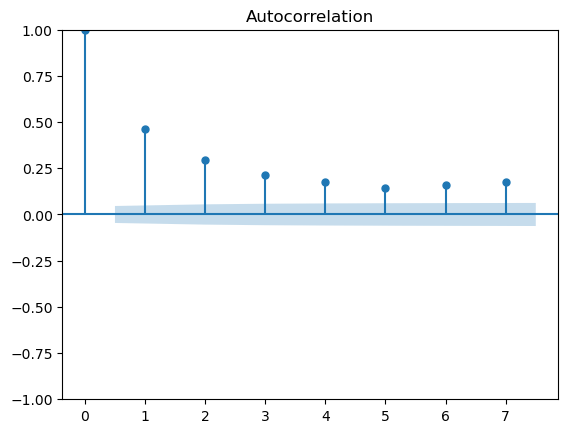

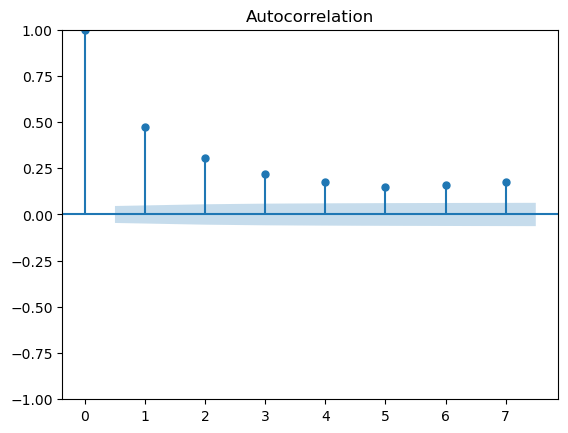

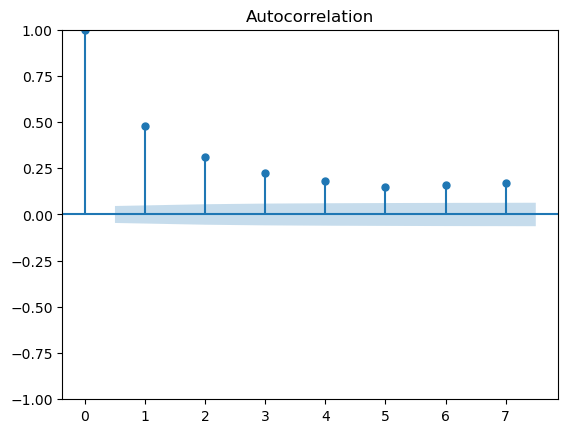

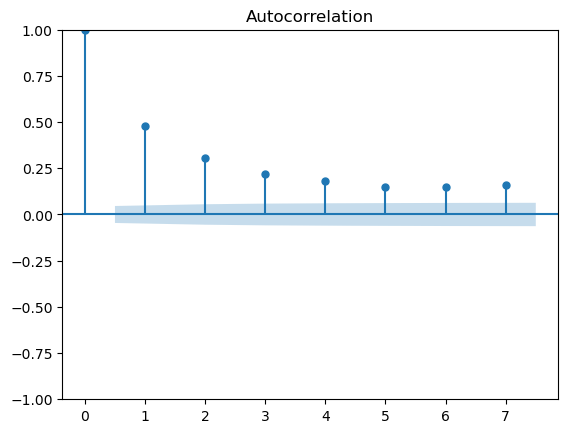

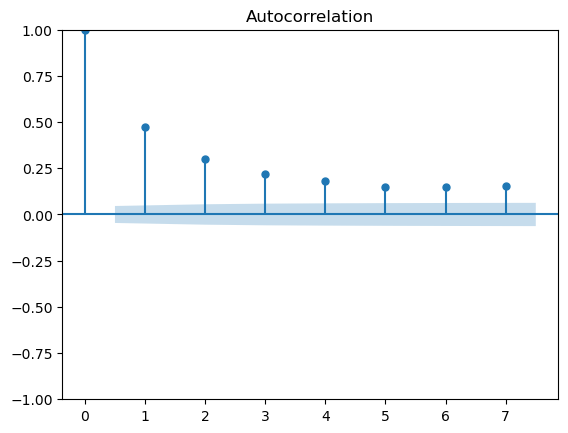

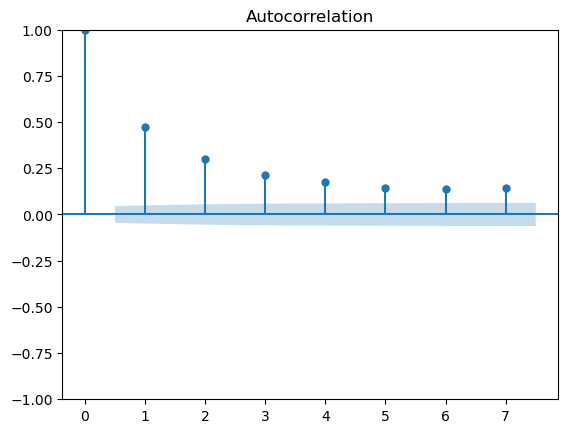

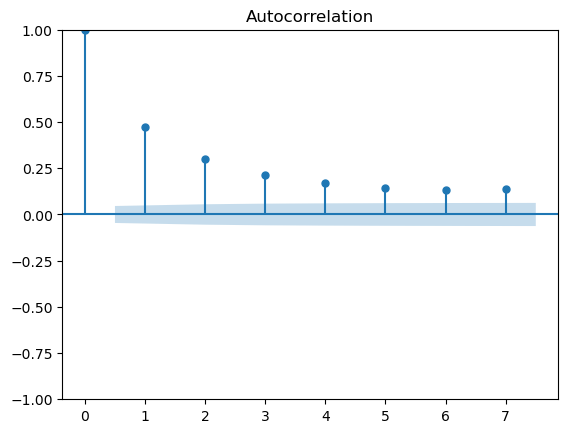

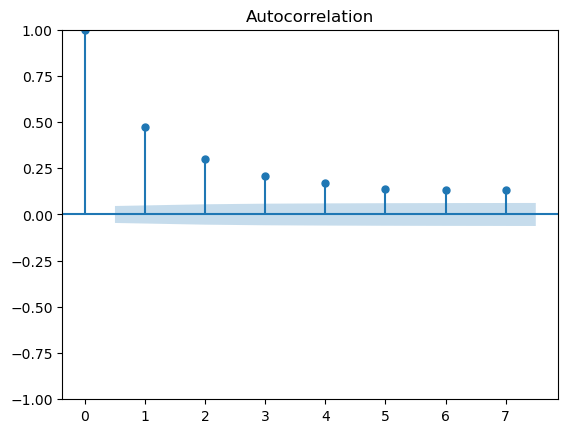

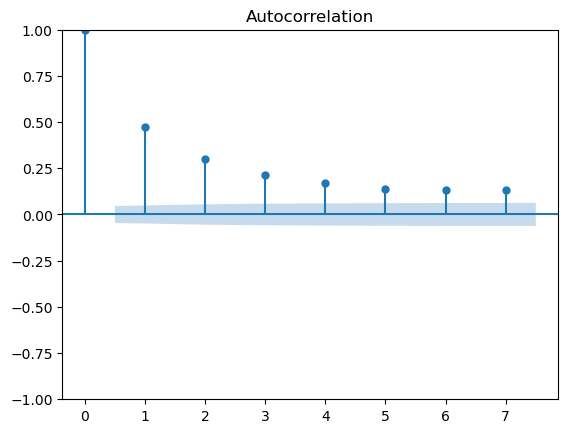

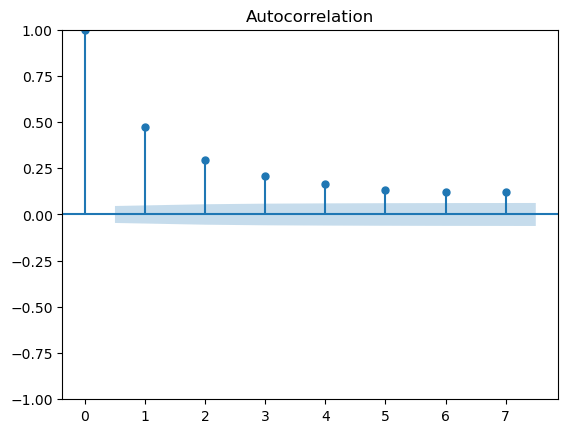

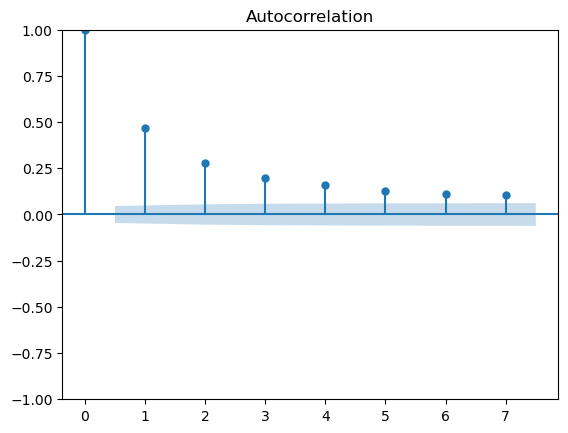

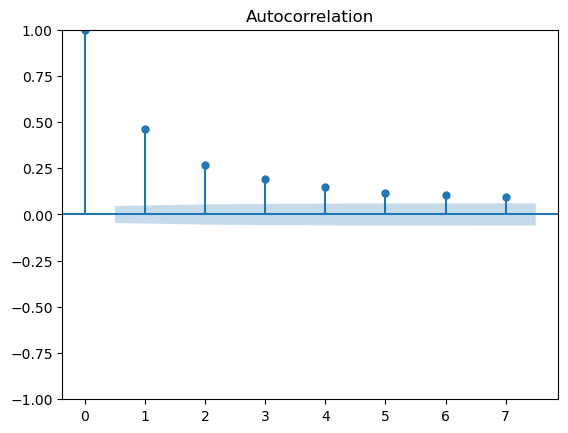

In [46]:
for i in range(23):
    tsaplots.plot_acf(df2[df2['Hour'] == i]['Wind Offshore'].dropna(), lags =7)

In [ ]:
# ONE PLOT PER YEAR?
# ASSIGN COLORS EACH YEAR?

# Scatter plot of electricity price and wind load
plt.scatter(df['Day-ahead prices'], df['Wind Total'], s = 0.5, c = df['Month'])
plt.xlabel('Day-ahead prices')
plt.ylabel('Wind Load')
plt.title('Electricity Price vs Wind Load')
plt.show()


In [ ]:
# Scatter plot of electricity price and wind load
df_masked = df[df['Year'] != 2022]
plt.scatter(df_masked['Day-ahead prices'], df_masked['Wind Total'], s = 0.5, c = df_masked['Year'])
plt.xlabel('Day-ahead prices')
plt.ylabel('Wind Load')
plt.title('Electricity Price vs Wind Load')
plt.show()

In [ ]:
# DISAGGREGATE PER YEAR
# Bar chart of average electricity price for each month
monthly_average = df.groupby(by = 'Month')['Day-ahead prices'].mean()
plt.bar(monthly_average.index, monthly_average.values)
plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('Average Electricity Price')
plt.title('Average Electricity Price by Month')
plt.show()

In [ ]:
# WHAT'S THAT
# Select random month
random_month = np.random.randint(1, 13)

# Filter data for the selected month
df_month = df[df['Month'] == random_month]

# Heatmap of correlations between variables
sns.heatmap(df_month.corr(), annot=True, cmap='coolwarm')
plt.title(f'Correlation Heatmap for {random_month}/{df_month["Year"].iloc[0]}')
plt.show()

In [ ]:
# ONE PLOT WITH 4/5 BOXES, ONE PER YEAR
# Boxplot of electricity prices for the selected month
sns.boxplot(y=df_month[df_month['Year'] != 2022]['Day-ahead prices'])
plt.title(f'Boxplot of Electricity Prices for {random_month}/{df_month["Year"].iloc[0]}') # CHANGE TITLE
plt.ylabel('Day-ahead prices')
plt.show()

In [ ]:
# Boxplot of electricity prices for the selected month
sns.boxplot(y=df_month['Day-ahead prices'])
plt.title(f'Boxplot of Electricity Prices for {random_month}/{df_month["Year"].iloc[0]}') # CHANGE TITLE
plt.ylabel('Day-ahead prices')
plt.show()

In [ ]:
# group the data by hour and calculate the mean of the 'total load' column
hourly_avg_load = df.groupby('Hour')['Actual Load'].mean()
hourly_avg_price = df.groupby('Hour')['Day-ahead prices'].mean()

In [ ]:
# groupby hour and year
# secondary axis
# plot the hourly average total load
plt.plot(hourly_avg_load.index, hourly_avg_load.values, label = 'Actual Load')
plt.plot(hourly_avg_price.index, hourly_avg_price.values, label = 'Prices')
plt.xlabel('Hour')
plt.title('Hourly Average Total Load')
plt.legend()
plt.show()